In [1]:
import numpy as np
from prospect.models import priors_beta as pb
from prospect.models import transforms as ts
import matplotlib.pyplot as plt
import lbg_forecast.cosmology as cosmology
import lbg_forecast.sfh as sfh
import lbg_forecast.modified_prospector_beta as mpb
import lbg_forecast.population_model as pop

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


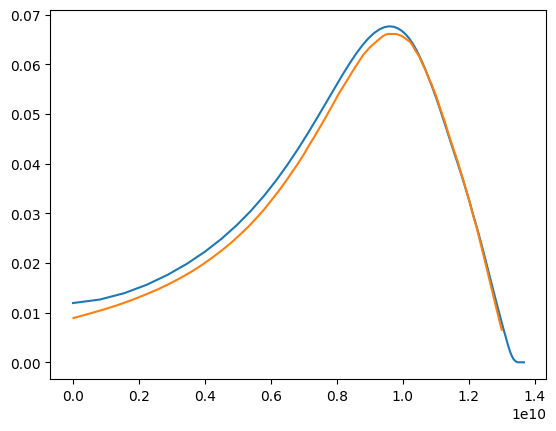

In [2]:
test_z, csfrd_sample= mpb.get_csfrd_prior()
lbtimes, csfrdspl = mpb.get_csfrd_spline(test_z, csfrd_sample)
plt.plot(pb.tl_b19, pb.sfrd_b19)
plt.plot(lbtimes, csfrdspl(lbtimes))

Text(0.5, 0, '$t_{L}/t_{\\mathrm{univ}}$')

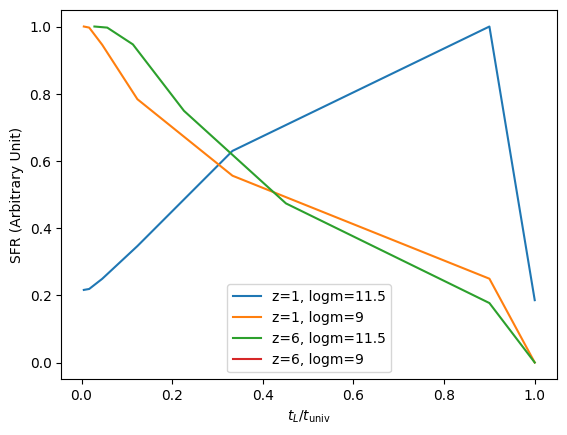

In [39]:
def get_sfr_curve(redshift, logmass):

    sigma = 0.000000000001
    agebins = sfh.default_agebins()

    logsfrratios = pop.modified_prospector_beta_sfh_prior(np.atleast_1d(redshift), np.atleast_1d(logmass), sigma)[0, :]

    agebins_pbeta = ts.zred_to_agebins_pbeta(np.array([redshift]), agebins)
    sfrs = ts.logsfr_ratios_to_sfrs(logmass, logsfrratios, agebins_pbeta)
    lookback_time = (10**agebins_pbeta[:, 1])/1e9
    tuniv = cosmology.get_wmap9().age(redshift)

    return lookback_time/tuniv, sfrs


redshift = 1
logmass = 11.5
x1, y1 = get_sfr_curve(redshift, logmass)

redshift = 6
logmass = 11.5
x2, y2 = get_sfr_curve(redshift, logmass)

redshift = 1
logmass = 9
x3, y3 = get_sfr_curve(redshift, logmass)

redshift = 6
logmass = 9
x4, y4 = get_sfr_curve(redshift, logmass)

plt.plot(x1.value, y1/np.max(y1), label="z=1, logm=11.5")
plt.plot(x3.value, y3/np.max(y3), label="z=1, logm=9")
plt.plot(x2.value, y2/np.max(y2), label="z=6, logm=11.5")
plt.plot(x4.value, y4/np.max(y4), label="z=6, logm=9")
plt.legend()

plt.ylabel("SFR (Arbitrary Unit)")
plt.xlabel("$t_{L}/t_{\mathrm{univ}}$")